In [ ]:
pip install spotipy

In [ ]:
pip install mysql-connector-python

# Database

Let's create and connect to a database

In [32]:
import sqlite3

database = sqlite3.connect('spotify.db')

Let's create a table for our streaming history

In [33]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS streaming_history(
                    endTime DATETIME,
                    artistName varchar(40),
                    trackName varchar(40),
                    msPlayed int,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

Now let's insert our streaming history JSON into the database.

In [34]:
import json

with open("/content/StreamingHistory0.json", 'r') as file:
  data = json.loads(file.read())

print(data[:4])

[{'endTime': '2020-06-24 07:45', 'artistName': 'Foo Fighters', 'trackName': 'These Days', 'msPlayed': 294417}, {'endTime': '2020-06-25 00:02', 'artistName': 'NF', 'trackName': 'One Hundred', 'msPlayed': 192800}, {'endTime': '2020-06-25 00:06', 'artistName': 'NF', 'trackName': 'Outro', 'msPlayed': 212186}, {'endTime': '2020-06-25 00:09', 'artistName': 'NF', 'trackName': 'Intro 2', 'msPlayed': 195933}]


In [35]:
keys = ["endTime", "artistName", "trackName", "msPlayed"]

for item in data:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO streaming_history VALUES(?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

Check if it worked

In [36]:
cmd = """SELECT * FROM streaming_history LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1)
('2020-06-25 00:02', 'NF', 'One Hundred', 192800, 2)
('2020-06-25 00:06', 'NF', 'Outro', 212186, 3)
('2020-06-25 00:09', 'NF', 'Intro 2', 195933, 4)
('2020-06-25 00:14', 'NF', 'Therapy Session', 331480, 5)


The target is now to create another table which contains the artist and the genre.

In [37]:
cmd = """SELECT DISTINCT artistName FROM streaming_history;"""
cur = database.execute(cmd)
artist_list = cur.fetchall()

print("We have " + str(len(artist_list)) + " different artists")

We have 1088 different artists


Let's get our spotify information

In [38]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [41]:
values = []

for item in artist_list:
  artistName = item[0]
  results = sp.search(q=artistName, type='artist')
  
  try:
    results = results["artists"]["items"][0]
    genres = results["genres"]

    for genre in genres:
      value = (artistName, genre)
      values.append(value)
    
  except:
    print("not found: " + artistName)


not found: Asaf Avidan & the Mojos
not found: Benny Benassi presents The Biz
not found: The Explicits
not found: Science Weekly


In [42]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS artist_genres(
                    artistName varchar(40),
                    genreName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [43]:
for value in values:
    cmd = """INSERT INTO artist_genres VALUES(?, ?, null);"""
    database.execute(cmd, value)

database.commit()

In [44]:
cmd = """SELECT * FROM artist_genres LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('Foo Fighters', 'alternative metal', 1)
('Foo Fighters', 'alternative rock', 2)
('Foo Fighters', 'modern rock', 3)
('Foo Fighters', 'permanent wave', 4)
('Foo Fighters', 'post-grunge', 5)


Let's try to get every modern rock from streaming history

In [68]:
def getGenreStreamingHistory(genre):
  cmd = """ SELECT streaming_history.endTime, streaming_history.artistName, streaming_history.trackName, artist_genres.genreName, streaming_history.msPlayed
            FROM streaming_history
            INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName 
            WHERE artist_genres.genreName='""" + genre + "';"
  cur = database.execute(cmd)
  streaming_history = cur.fetchall()
  return streaming_history

modern_rock_streaming_history = getGenreStreamingHistory("modern rock")
print(modern_rock_streaming_history[:3])

[('2020-06-24 07:45', 'Foo Fighters', 'These Days', 'modern rock', 294417), ('2020-06-28 15:20', 'Foo Fighters', 'Concrete and Gold', 'modern rock', 0), ('2020-07-01 13:25', 'Foo Fighters', 'These Days', 'modern rock', 298266)]


Now let's look at the streaming time.

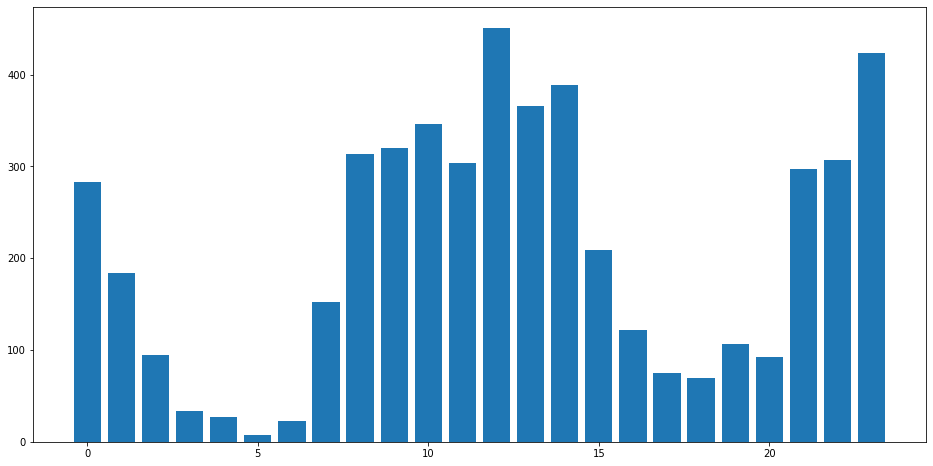

In [113]:
from datetime import datetime
import matplotlib.pyplot as plt
          
def getHourlyStreamingHistoryCount(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    hours[date.hour] += 1
  
  return hours

def getHourlyStreamingHistoryTime(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    sec = t[4] / 1000 #seconds played
    min = sec / 60 #minute played
    hours[date.hour] += min
  
  return hours

def plotHourlyStreamingHistory(hours):
  y = [y for y in range(24)]
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

modern_rock_hourly_history = getHourlyStreamingHistoryTime(modern_rock_streaming_history)
plotHourlyStreamingHistory(modern_rock_hourly_history)

Let's compare that to metal

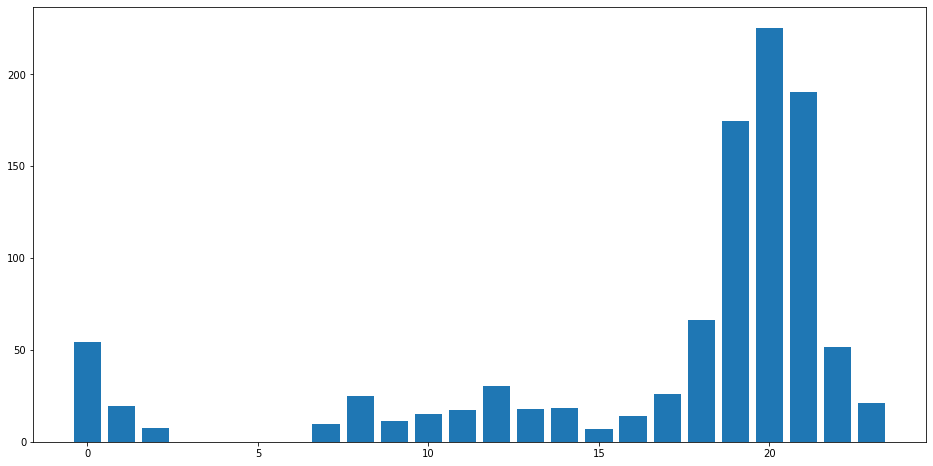

In [114]:
heavy_metal_streaming_history = getGenreStreamingHistory("metal")
heavy_metal_hourly_history = getHourlyStreamingHistoryTime(heavy_metal_streaming_history)
plotHourlyStreamingHistory(heavy_metal_hourly_history)

To be able to better compare what's going on, let's look at which are the most popular genres and then plot them against each other.

In [104]:
cmd = """ SELECT genreName, SUM(msPlayed)/(60*1000) FROM
          (
          SELECT artist_genres.genreName, streaming_history.trackName, streaming_history.msPlayed
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName
          )
          GROUP BY genreName
          ORDER BY SUM(msPlayed) DESC;
          """


cur = database.execute(cmd)
res = cur.fetchall()
print("So my most popular streamed genres:")
for i in range(50):
  print(res[i][0] + " : " + str(res[i][1]) + " min")

So my most popular streamed genres:
rock : 9050 min
modern rock : 4997 min
classic rock : 4017 min
pop : 3813 min
album rock : 3626 min
mellow gold : 2855 min
soft rock : 2640 min
art rock : 2582 min
hard rock : 2127 min
permanent wave : 2032 min
progressive rock : 1912 min
glam rock : 1783 min
alternative rock : 1743 min
piano rock : 1734 min
alternative metal : 1538 min
indie rock : 1530 min
electropop : 1388 min
modern alternative rock : 1374 min
pop rock : 1368 min
indie poptimism : 1270 min
dance pop : 1119 min
nu metal : 1111 min
edm : 1077 min
metal : 1003 min
pop dance : 968 min
french indie pop : 964 min
tropical house : 954 min
rap : 937 min
pop rap : 913 min
indie pop : 870 min
hip hop : 866 min
metropopolis : 802 min
electro house : 766 min
post-teen pop : 761 min
indietronica : 758 min
psychedelic rock : 701 min
french indietronica : 700 min
new french touch : 631 min
lancaster pa indie : 601 min
french synthpop : 588 min
blues rock : 571 min
filter house : 564 min
electro

Let's look at that on a pie plot.

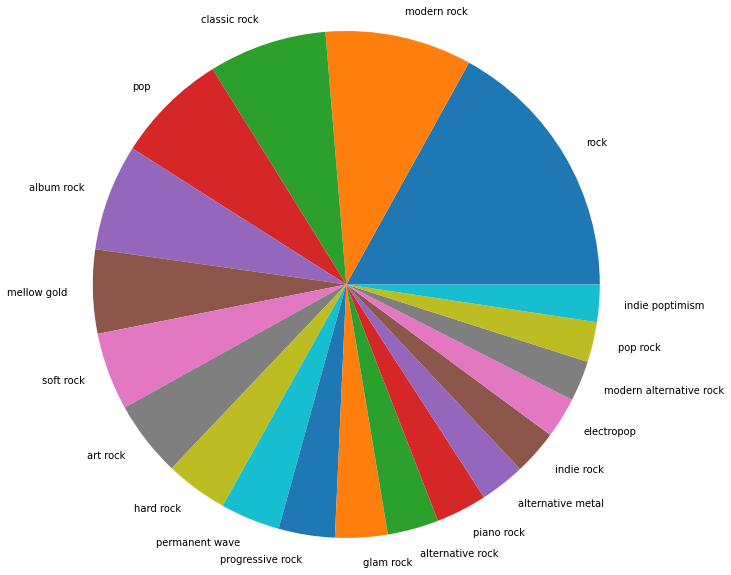

In [156]:
labels = []
sizes = []

for i in range(20):
  labels.append(res[i][0])
  sizes.append(res[i][1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels)
ax.axis('equal')

plt.show()

Let's take some different genres.

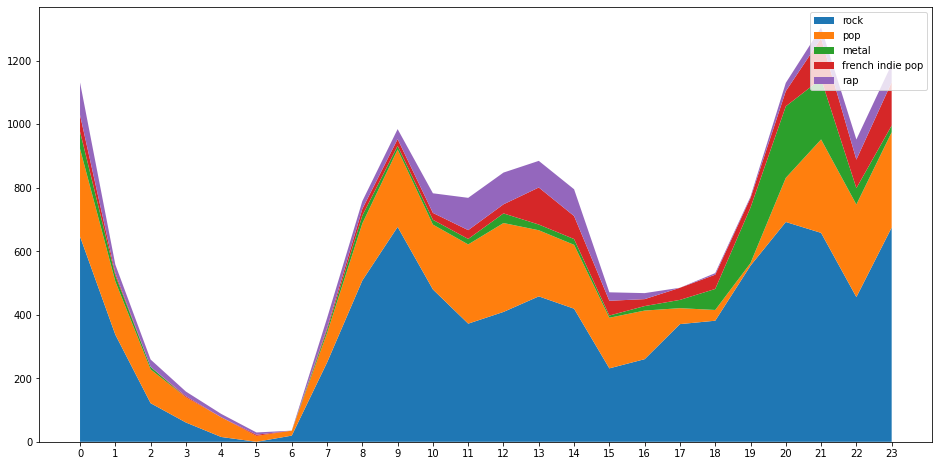

In [149]:
labels = [str(y) for y in range(24)]
genres = ["rock", "pop", "metal", "french indie pop", "rap"]
fig, ax = plt.subplots(figsize=(16, 8))

hours = {}

for genre in genres:
  hourly = getHourlyStreamingHistoryTime(getGenreStreamingHistory(genre))
  hours[genre] = hourly

ax.stackplot(labels, hours.values(),
             labels=hours.keys())

ax.legend()
plt.show()

In [ ]:
#close
database.close()

# Playlist analysis

In [ ]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

features = get_tracks_features(tracks)